# HW3: LASSO

## Imports

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.datasets import make_regression

## Barrier method

In this part we want to solve the centering step problem: 
$\min_{\nu} g_{t}(\nu) = t \left( \nu^{T} Q \nu + p^{T} \nu \right) - \sum_{i=1}^{2d} \log \left( b_i - \left[ A \nu \right]_{i} \right)$

for clarity purposes we consider: 

$f=\nu^{T} Q \nu + p^{T} \nu$

$h_i=b_i - \left[ A \nu \right]_{i}$

And as computed: 

$\nabla g_{t} (\nu) =  t \left( 2 Q \nu + p \right) + \sum_{i=1}^{2d} \left( b_i - a_i^T \nu \right)^{-1} a_i$

$\nabla^2 g_t = 2 t \cdot Q + A^T Diag \left( \mu \right)^2 A$

with $\mu = \left( \left( b_1 - a_1^T \nu \right)^{-1}, \dots, \left( b_{2d} - a_{2d}^T \nu \right)^{-1} \right)^T$

In [114]:
# The function f and the objective function
def f(Q, p, v) :
    return np.dot(np.dot(v.T,Q),v) + np.dot(p.T,v)

def Objective( Q, p, A, b, t,v):
    if (b - np.dot(A,v) <= 0).any():
        return None
    return t * f(Q, p, v) - np.sum(np.log(b - np.dot(A,v)))

In [115]:
##Gradient and Hessian 

# The gradient of the objective function
def gradient (Q, p, A, b, t, v) :
    
    df = 2 * np.dot(Q,v) + p
    dhi = np.dot(-A.T , 1/(b - np.dot(A,v)))
    
    return t * df - dhi 

# The hessian of the objective function
def hessian (Q, p, A, b, t, v) : 
    
    ddf = 2 * Q 
    mu  = (1 /((b - np.dot(A,v))**2))
    ddhi = np.dot(np.dot(-A.T , np.diag(mu)), A)
    
    return (t * ddf - ddhi)

In [116]:
#Line search 
def line_search(Q, p, A, b, t, v, dv):
    step = 1

    while True : 
        
        v_new = v + step *dv
        if Objective(Q, p, A, b, t,v_new) != None : 
            if Objective(Q, p, A, b, t, v_new) >= Objective(Q, p, A, b, t, v) + alpha * step * np.dot((gradient(Q, p, A, b, t, v)).T, dv):
                step= step* beta
            else: 
                break 
        else : 
            break
    
    return step

In [117]:
# The centering step function 
def centering_step (Q, p, A, b, t, v0, eps,max_iter=400) : 
    
    #initialisation
    v_seq = [v0]
    v = v0
    i = 0

    while i<max_iter :
        
        df = gradient(Q, p, A, b, t, v)
        ddf = hessian(Q, p, A, b, t, v)

        dv = - np.dot(np.linalg.pinv(ddf),df)

        # stopping criterion
        lambda2 = - df.T @ dv
        if lambda2 / 2 <= eps : 
            break 
            
        step = line_search(Q, p, A, b, t, v, dv)       
        v = v + step * dv 
        v_seq.append(v)
        i += 1
    
    return v_seq, i

In [118]:
# The barrier method to solve QP 
def barrier_method (Q, p, A, b, v0, eps) : 
    #initialisation
    m = A.shape[0]   
    v = v0 
    step = step0
    v_seq = [v0]
    num_iter = 0
  
    while (m/step)>= eps : 
        v, i = centering_step(Q, p, A, b, step, v, 1e-5)
        v = v[-1]
        v_seq.append(v)
        num_iter += i
        step= step * mu 

    return (v_seq , num_iter) 

## Test

In [119]:
def random_initial(n,d,r):
    X = 3 * np.random.randn(n, d)
    y = 5 + 1.5 * np.random.randn(n)

    Q = np.eye(n) / 2
    p = - y

    A = np.concatenate((X.T, - X.T), axis=0)
    b = r * np.ones(2 * d)

    v0 = np.zeros(n)

    return X, y, Q, p, A, b, v0

In [120]:
#Paraneters
# dimensions
n ,d ,r = 20,50, 10

# Random Initialization 
X, y, Q, p, A, b, v0 = random_initial(n, d, r)

#computation parameter
eps = 1e-3
step0 = 1
alpha  = 0.01 
beta = 0.5 
mu_list = [2, 10, 15, 30, 50, 100, 150, 200, 300, 500]

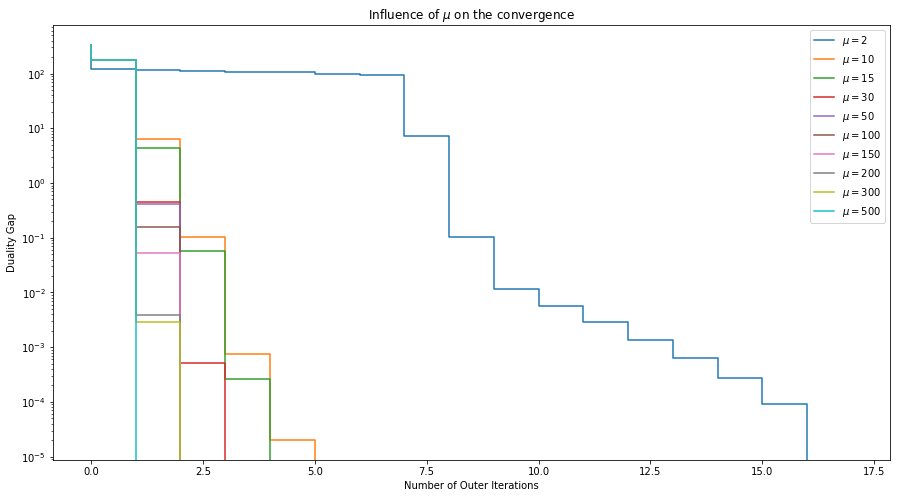

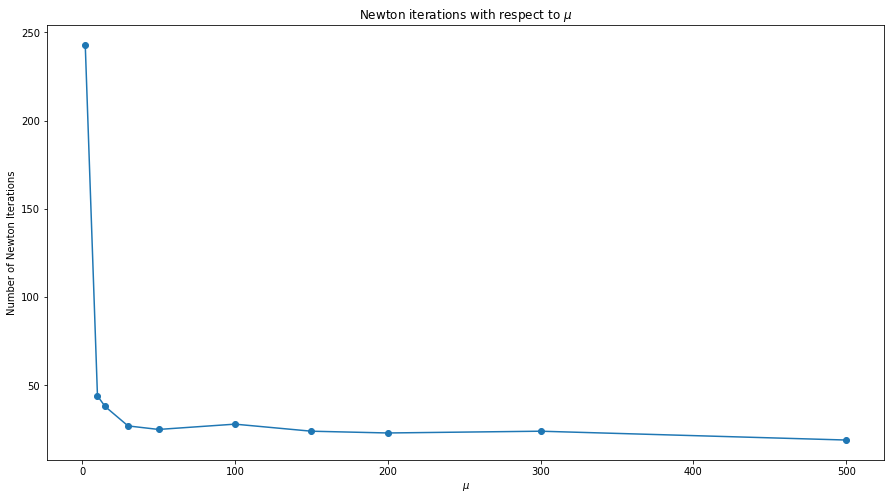

In [121]:
plt.figure(figsize=(15,8))

iter_list =[]
objective = []

for mu in mu_list : 
    
    v_seq , num_iter = barrier_method (Q, p, A, b, v0, eps)
    iter_list.append(num_iter)
    gap =[]
    
    for v in v_seq :
        diff = f (Q, p, v) - f (Q, p, v_seq[-1])
        #print(diff)
        gap.append(diff)
        #print(f (Q, p, v))
    objective.append(f (Q, p, v_seq[-1]))
        
    itr = range(len(gap))
    plt.step(itr , gap)
   
plt.semilogy()
plt.xlabel("Number of Outer Iterations")
plt.ylabel("Duality Gap")
plt.legend(['$\mu = $' + str(x) for x in mu_list])
plt.title('Influence of $\\mu$ on the convergence ')
plt.savefig("dual_gap")
plt.show()

plt.figure(figsize=(15,8))
plt.plot(mu_list , iter_list , marker = 'o')
plt.ylabel("Number of Newton Iterations")
plt.xlabel('$\mu$')
plt.title('Newton iterations with respect to $\mu$')
plt.show()